## Neural networks
### mental model of learning
![](../images/model_of_learning.png)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

In [63]:
# same example data as chapter 5
t_c = torch.tensor([0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]) # in celcius
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]) # in unknown unit
# This makes the size (11) to (11,1)
# basically we added an extra dimension of "1" at the end
# Pytorch expects batch size at the 0th position
# here the batch size is 11 (11 data points) and there is just one feature(the temp). That's why we do that.
# WE want to reshape it in that form before passing it to the network, as it expects it in that form.
t_c = torch.tensor(t_c).unsqueeze(1)  
t_u = torch.tensor(t_u).unsqueeze(1)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

ipykernel_launcher:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
ipykernel_launcher:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(tensor([9, 8, 0, 3, 2, 5, 1, 4, 7]), tensor([10,  6]))

In [64]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [65]:
t_un_val.size()

torch.Size([2, 1])

In [66]:
# has a __call__ method defined already, which sets up "hooks",ie, things for the forward call to work correctly
linear_model = nn.Linear(1,1) #(input and output tensor size)
linear_model(t_un_val) # alternative to calling forward with the same arguments

tensor([[-5.6589],
        [-2.5575]], grad_fn=<AddmmBackward>)

In [67]:
linear_model.weight

Parameter containing:
tensor([[-0.8990]], requires_grad=True)

In [68]:
linear_model.bias

Parameter containing:
tensor([0.4899], requires_grad=True)

In [69]:
# can have results for a batch, where the zeroth dimension withh be the batch size
linear_model(torch.ones(10,1))

tensor([[-0.4090],
        [-0.4090],
        [-0.4090],
        [-0.4090],
        [-0.4090],
        [-0.4090],
        [-0.4090],
        [-0.4090],
        [-0.4090],
        [-0.4090]], grad_fn=<AddmmBackward>)

## using the linear model
- it's in the nn module, but, not a neural network yet.
- Even the results we get are the exact same as before.

In [70]:
def training_loop(n_epochs, model, optimizer, loss_fn, t_u_train, t_c_train, t_u_val, t_c_val):
    for i in range(1, n_epochs+1):
        optimizer.zero_grad()

        train_predicted = model(t_u_train)
        train_loss = loss_fn(train_predicted, t_c_train)
        val_loss = loss_fn(model(t_u_val), t_c_val)
        train_loss.backward() # calc gradients
        optimizer.step() # update parameters

        if i%500==0:
            print(f"epoch {i} training loss {train_loss}, validation loss {val_loss}") 

In [71]:
linear_model = nn.Linear(1, 1) # one input and output feature (the temperature)
## the optimizer with optimize the params of the linear model
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 5000,
    model = linear_model,
    optimizer = optimizer,
    loss_fn = nn.MSELoss(), # MSELoss is a class, we instantiate it and pass the function to the loop
    t_u_train = t_un_train,
    t_c_train = t_c_train,
    t_u_val = t_un_val,
    t_c_val = t_c_val,

)
print(list(linear_model.parameters()))

epoch 500 training loss 8.659355163574219, validation loss 7.074272155761719
epoch 1000 training loss 3.8009579181671143, validation loss 4.253093242645264
epoch 1500 training loss 2.8559889793395996, validation loss 4.459417343139648
epoch 2000 training loss 2.6721911430358887, validation loss 4.8325395584106445
epoch 2500 training loss 2.636443614959717, validation loss 5.051978588104248
epoch 3000 training loss 2.629490613937378, validation loss 5.159413814544678
epoch 3500 training loss 2.6281378269195557, validation loss 5.208893775939941
epoch 4000 training loss 2.627875328063965, validation loss 5.231110572814941
epoch 4500 training loss 2.627823829650879, validation loss 5.240985870361328
epoch 5000 training loss 2.6278128623962402, validation loss 5.2453765869140625
[Parameter containing:
tensor([[5.4199]], requires_grad=True), Parameter containing:
tensor([-17.9863], requires_grad=True)]



## Using a neural network!
The above example was same as in ch5 - a linear model, ie, a straight line here. But we love them curves out here, so let's get down and dirty with some nonlinearity.

Using a neural network wont be better, as the modelling is fundamentally linear. We're just trying it out here.



In [72]:
# a simple, stacked neural network. Linear->activation->Linear
# we can also name layers by passing an ordereddict!
seq_model = nn.Sequential(
    nn.Linear(1,13), # 13 could be anything
    nn.Tanh(), # this is what adds nonlinearity and makes it a neural network.
    nn.Linear(13,1)
)
seq_model # bias=True means we have the 'c' in y=mx+c in the linear layer

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [75]:
list(seq_model.parameters()) # these are the tensors that the optimizer will get and optimize. note, they all have requires_grad=True

[Parameter containing:
 tensor([[-0.7298],
         [ 0.3996],
         [ 0.9667],
         [ 0.0909],
         [ 0.0098],
         [-0.5687],
         [-0.5159],
         [ 0.5618],
         [-0.0214],
         [ 0.4691],
         [ 0.8804],
         [ 0.4126],
         [ 0.9021]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2251,  0.4664, -0.6297,  0.7492, -0.2880,  0.5283,  0.0063, -0.4760,
         -0.2166,  0.0279,  0.6899, -0.5994,  0.1109], requires_grad=True),
 Parameter containing:
 tensor([[-0.1727, -0.0044,  0.1594, -0.2581, -0.2320, -0.0242, -0.0350, -0.2641,
          -0.0302,  0.0539, -0.2353, -0.0251,  0.1418]], requires_grad=True),
 Parameter containing:
 tensor([0.0382], requires_grad=True)]

In [77]:
# makes it easy to interpret what the parameters are for
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [80]:

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    model = seq_model,
    optimizer = optimizer,
    loss_fn = nn.MSELoss(), # MSELoss is a class, we instantiate it and pass the function to the loop
    t_u_train = t_un_train,
    t_c_train = t_c_train,
    t_u_val = t_un_val,
    t_c_val = t_c_val,

)
# print(list(seq_model.parameters())) # note, params not interpretable anymore

## if the layers were named with OrderedDict, we could have printed out hidden info like
# seq_model.hidden_linear.weight.grad

epoch 500 training loss 1.520435094833374, validation loss 4.976808547973633
epoch 1000 training loss 1.518537998199463, validation loss 5.0050272941589355
epoch 1500 training loss 1.516756534576416, validation loss 5.0323381423950195
epoch 2000 training loss 1.5150753259658813, validation loss 5.058743000030518
epoch 2500 training loss 1.5134791135787964, validation loss 5.0846076011657715
epoch 3000 training loss 1.5119596719741821, validation loss 5.1099443435668945
epoch 3500 training loss 1.5105026960372925, validation loss 5.134762287139893
epoch 4000 training loss 1.5091010332107544, validation loss 5.159358978271484
epoch 4500 training loss 1.5077471733093262, validation loss 5.183654308319092
epoch 5000 training loss 1.506432294845581, validation loss 5.207746505737305


### visualize (hint : not a straight line)

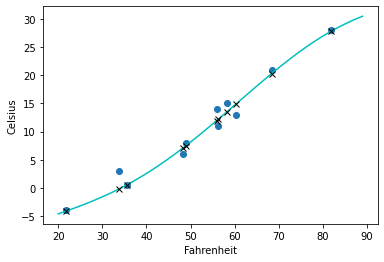

In [84]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
# fig = plt.figure(dpi=600) # higher res and bigger
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')